In [1]:
%matplotlib inline
from fenics import *
import sys

In [2]:
import pkg_resources
pkg_resources.get_distribution("fenics").version

'2018.1.0'

In [3]:
# %load ~/demo/python/documented/poisson/demo_poisson.py
# 
# .. _demo_poisson_equation:
# 
# Poisson equation
# ================
# 
# This demo is implemented in a single Python file,
# :download:`demo_poisson.py`, which contains both the variational forms
# and the solver.
# 
# This demo illustrates how to:
# 
# * Solve a linear partial differential equation
# * Create and apply Dirichlet boundary conditions
# * Define Expressions
# * Define a FunctionSpace
# * Create a SubDomain
# 
# The solution for :math:`u` in this demo will look as follows:
# 
# .. image:: poisson_u.png
#    :scale: 75 %
# 
# 
# Equation and problem definition
# -------------------------------
# 
# The Poisson equation is the canonical elliptic partial differential
# equation.  For a domain :math:`\Omega \subset \mathbb{R}^n` with
# boundary :math:`\partial \Omega = \Gamma_{D} \cup \Gamma_{N}`, the
# Poisson equation with particular boundary conditions reads:
# 
# .. math::
#    - \nabla^{2} u &= f \quad {\rm in} \ \Omega, \\
#                 u &= 0 \quad {\rm on} \ \Gamma_{D}, \\
#                 \nabla u \cdot n &= g \quad {\rm on} \ \Gamma_{N}. \\
# 
# Here, :math:`f` and :math:`g` are input data and :math:`n` denotes the
# outward directed boundary normal. The most standard variational form
# of Poisson equation reads: find :math:`u \in V` such that
# 
# .. math::
#    a(u, v) = L(v) \quad \forall \ v \in V,
# 
# where :math:`V` is a suitable function space and
# 
# .. math::
#    a(u, v) &= \int_{\Omega} \nabla u \cdot \nabla v \, {\rm d} x, \\
#    L(v)    &= \int_{\Omega} f v \, {\rm d} x
#    + \int_{\Gamma_{N}} g v \, {\rm d} s.
# 
# The expression :math:`a(u, v)` is the bilinear form and :math:`L(v)`
# is the linear form. It is assumed that all functions in :math:`V`
# satisfy the Dirichlet boundary conditions (:math:`u = 0 \ {\rm on} \
# \Gamma_{D}`).
# 
# In this demo, we shall consider the following definitions of the input
# functions, the domain, and the boundaries:
# 
# * :math:`\Omega = [0,1] \times [0,1]` (a unit square)
# * :math:`\Gamma_{D} = \{(0, y) \cup (1, y) \subset \partial \Omega\}`
#   (Dirichlet boundary)
# * :math:`\Gamma_{N} = \{(x, 0) \cup (x, 1) \subset \partial \Omega\}`
#   (Neumann boundary)
# * :math:`g = \sin(5x)` (normal derivative)
# * :math:`f = 10\exp(-((x - 0.5)^2 + (y - 0.5)^2) / 0.02)` (source
#   term)
# 
# 
# Implementation
# --------------
# 
# This description goes through the implementation (in
# :download:`demo_poisson.py`) of a solver for the above described
# Poisson equation step-by-step.
# 
# First, the :py:mod:`dolfin` module is imported: ::

from dolfin import *

# We begin by defining a mesh of the domain and a finite element
# function space :math:`V` relative to this mesh. As the unit square is
# a very standard domain, we can use a built-in mesh provided by the
# class :py:class:`UnitSquareMesh <dolfin.cpp.UnitSquareMesh>`. In order
# to create a mesh consisting of 32 x 32 squares with each square
# divided into two triangles, we do as follows ::

# Create mesh and define function space
mesh = UnitSquareMesh(32, 32)
V = FunctionSpace(mesh, "Lagrange", 1)

# The second argument to :py:class:`FunctionSpace
# <dolfin.functions.functionspace.FunctionSpace>` is the finite element
# family, while the third argument specifies the polynomial
# degree. Thus, in this case, our space ``V`` consists of first-order,
# continuous Lagrange finite element functions (or in order words,
# continuous piecewise linear polynomials).
# 
# Next, we want to consider the Dirichlet boundary condition. A simple
# Python function, returning a boolean, can be used to define the
# subdomain for the Dirichlet boundary condition (:math:`\Gamma_D`). The
# function should return ``True`` for those points inside the subdomain
# and ``False`` for the points outside. In our case, we want to say that
# the points :math:`(x, y)` such that :math:`x = 0` or :math:`x = 1` are
# inside on the inside of :math:`\Gamma_D`. (Note that because of
# rounding-off errors, it is often wise to instead specify :math:`x <
# \epsilon` or :math:`x > 1 - \epsilon` where :math:`\epsilon` is a
# small number (such as machine precision).) ::

# Define Dirichlet boundary (x = 0 or x = 1)
def boundary(x):
    return x[0] < DOLFIN_EPS or x[0] > 1.0 - DOLFIN_EPS

# Now, the Dirichlet boundary condition can be created using the class
# :py:class:`DirichletBC <dolfin.fem.bcs.DirichletBC>`. A
# :py:class:`DirichletBC <dolfin.fem.bcs.DirichletBC>` takes three
# arguments: the function space the boundary condition applies to, the
# value of the boundary condition, and the part of the boundary on which
# the condition applies. In our example, the function space is ``V``,
# the value of the boundary condition (0.0) can represented using a
# :py:class:`Constant <dolfin.functions.constant.Constant>` and the
# Dirichlet boundary is defined immediately above. The definition of the
# Dirichlet boundary condition then looks as follows: ::

# Define boundary condition
u0 = Constant(0.0)
bc = DirichletBC(V, u0, boundary)

# Next, we want to express the variational problem.  First, we need to
# specify the trial function :math:`u` and the test function :math:`v`,
# both living in the function space :math:`V`. We do this by defining a
# :py:class:`TrialFunction <dolfin.functions.function.TrialFunction>`
# and a :py:class:`TestFunction
# <dolfin.functions.function.TrialFunction>` on the previously defined
# :py:class:`FunctionSpace
# <dolfin.functions.functionspace.FunctionSpace>` ``V``.
# 
# Further, the source :math:`f` and the boundary normal derivative
# :math:`g` are involved in the variational forms, and hence we must
# specify these. Both :math:`f` and :math:`g` are given by simple
# mathematical formulas, and can be easily declared using the
# :py:class:`Expression <dolfin.functions.expression.Expression>` class.
# Note that the strings defining ``f`` and ``g`` use C++ syntax since,
# for efficiency, DOLFIN will generate and compile C++ code for these
# expressions at run-time.
# 
# With these ingredients, we can write down the bilinear form ``a`` and
# the linear form ``L`` (using UFL operators). In summary, this reads ::

# Define variational problem
u = TrialFunction(V)
v = TestFunction(V)
f = Expression("10*exp(-(pow(x[0] - 0.5, 2) + pow(x[1] - 0.5, 2)) / 0.02)", degree=2)
g = Expression("sin(5*x[0])", degree=2)
a = inner(grad(u), grad(v))*dx
L = f*v*dx + g*v*ds

# Now, we have specified the variational forms and can consider the
# solution of the variational problem. First, we need to define a
# :py:class:`Function <dolfin.functions.function.Function>` ``u`` to
# represent the solution. (Upon initialization, it is simply set to the
# zero function.) A :py:class:`Function
# <dolfin.functions.function.Function>` represents a function living in
# a finite element function space. Next, we can call the :py:func:`solve
# <dolfin.fem.solving.solve>` function with the arguments ``a == L``,
# ``u`` and ``bc`` as follows: ::

# Compute solution
u = Function(V)
solve(a == L, u, bc)

# The function ``u`` will be modified during the call to solve. The
# default settings for solving a variational problem have been
# used. However, the solution process can be controlled in much more
# detail if desired.
# 
# A :py:class:`Function <dolfin.functions.function.Function>` can be
# manipulated in various ways, in particular, it can be plotted and
# saved to file. Here, we output the solution to a ``VTK`` file (using
# the suffix ``.pvd``) for later visualization and also plot it using
# the :py:func:`plot <dolfin.common.plot.plot>` command: ::

# Save solution in VTK format
file = File("poisson.pvd")
file << u

# Plot solution
import matplotlib.pyplot as plt
plot(u)
plt.show()


------------------- Start compiler output ------------------------
/var/folders/k1/216q5nr56td2vvg1xf5kvl600000gn/T/tmpxyy7nepu/dolfin_expression_6c0812a7fee76a04128d51ef14ea30ea.cpp:44:14: warning: unused variable 'pi' [-Wunused-const-variable]
const double pi = DOLFIN_PI;
             ^
1 warning generated.
ld: warning: ignoring file /Library/Developer/CommandLineTools/SDKs/MacOSX10.14.sdk/usr/lib/libpthread.tbd, file was built for unsupported file format ( 0x2D 0x2D 0x2D 0x20 0x21 0x74 0x61 0x70 0x69 0x2D 0x74 0x62 0x64 0x2D 0x76 0x33 ) which is not the architecture being linked (x86_64): /Library/Developer/CommandLineTools/SDKs/MacOSX10.14.sdk/usr/lib/libpthread.tbd
ld: warning: ignoring file /Library/Developer/CommandLineTools/SDKs/MacOSX10.14.sdk/usr/lib/libdl.tbd, file was built for unsupported file format ( 0x2D 0x2D 0x2D 0x20 0x21 0x74 0x61 0x70 0x69 0x2D 0x74 0x62 0x64 0x2D 0x76 0x33 ) which is not the architecture being linked (x86_64): /Library/Developer/CommandLineTools/SD

RuntimeError: Unable to compile C++ code with dijitso

In [18]:
# %load ./demo_navier-stokes.py
"""This demo program solves the incompressible Navier-Stokes equations
on an L-shaped domain using Chorin's splitting method."""

# Copyright (C) 2010-2011 Anders Logg
#
# This file is part of DOLFIN.
#
# DOLFIN is free software: you can redistribute it and/or modify
# it under the terms of the GNU Lesser General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.
#
# DOLFIN is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the
# GNU Lesser General Public License for more details.
#
# You should have received a copy of the GNU Lesser General Public License
# along with DOLFIN. If not, see <http://www.gnu.org/licenses/>.
#
# Modified by Mikael Mortensen 2011
#
# First added:  2010-08-30
# Last changed: 2011-06-30

# Begin demo

from dolfin import *

# Print log messages only from the root process in parallel
parameters["std_out_all_processes"] = False;

# Load mesh from file
mesh = Mesh("./lshape.xml")

# Define function spaces (P2-P1)
V = VectorFunctionSpace(mesh, "Lagrange", 2)
Q = FunctionSpace(mesh, "Lagrange", 1)

# Define trial and test functions
u = TrialFunction(V)
p = TrialFunction(Q)
v = TestFunction(V)
q = TestFunction(Q)

# Set parameter values
dt = 0.1
T = 3
nu = 0.01

# Define time-dependent pressure boundary condition
p_in = Expression("sin(3.0*t)", t=0.0, degree=2)

# Define boundary conditions
noslip  = DirichletBC(V, (0, 0),
                      "on_boundary && \
                       (x[0] < DOLFIN_EPS | x[1] < DOLFIN_EPS | \
                       (x[0] > 0.5 - DOLFIN_EPS && x[1] > 0.5 - DOLFIN_EPS))")
inflow  = DirichletBC(Q, p_in, "x[1] > 1.0 - DOLFIN_EPS")
outflow = DirichletBC(Q, 0, "x[0] > 1.0 - DOLFIN_EPS")
bcu = [noslip]
bcp = [inflow, outflow]

# Create functions
u0 = Function(V)
u1 = Function(V)
p1 = Function(Q)

# Define coefficients
k = Constant(dt)
f = Constant((0, 0))

# Tentative velocity step
F1 = (1/k)*inner(u - u0, v)*dx + inner(grad(u0)*u0, v)*dx + \
     nu*inner(grad(u), grad(v))*dx - inner(f, v)*dx
a1 = lhs(F1)
L1 = rhs(F1)

# Pressure update
a2 = inner(grad(p), grad(q))*dx
L2 = -(1/k)*div(u1)*q*dx

# Velocity update
a3 = inner(u, v)*dx
L3 = inner(u1, v)*dx - k*inner(grad(p1), v)*dx

# Assemble matrices
A1 = assemble(a1)
A2 = assemble(a2)
A3 = assemble(a3)

# Use amg preconditioner if available
prec = "amg" if has_krylov_solver_preconditioner("amg") else "default"

# Create files for storing solution
ufile = File("results/velocity.pvd")
pfile = File("results/pressure.pvd")

# Time-stepping
t = dt
while t < T + DOLFIN_EPS:

    # Update pressure boundary condition
    p_in.t = t

    # Compute tentative velocity step
#     print("Computing tentative velocity")
    b1 = assemble(L1)
    [bc.apply(A1, b1) for bc in bcu]
    solve(A1, u1.vector(), b1, "gmres", "default")
#     print()

    # Pressure correction
#     print("Computing pressure correction")
    b2 = assemble(L2)
    [bc.apply(A2, b2) for bc in bcp]
    solve(A2, p1.vector(), b2, "gmres", prec)
#     print()

    # Velocity correction
#     print("Computing velocity correction")
    b3 = assemble(L3)
    [bc.apply(A3, b3) for bc in bcu]
    solve(A3, u1.vector(), b3, "gmres", "default")
#     print()

#     # Plot solution
#     plot(p1, title="Pressure", rescale=True)
#     plot(u1, title="Velocity", rescale=True)

    # Save to file
    ufile << u1
    pfile << p1

    # Move to next time step
    u0.assign(u1)
    t += dt
#     print("t =", t)
    sys.stdout.write('>')



>>>>>>>>>>>>>>>>>>>>>>>>>>>>>

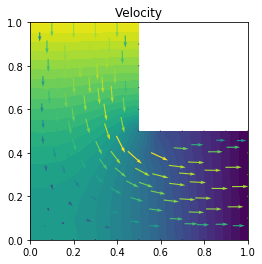

In [19]:
plot(p1, title="Pressure", rescale=True)
# Hold plot
# interactive()#deprecated code
plot(u1, title="Velocity", rescale=True)